In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


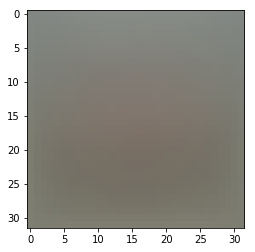

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [6]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.906335


In [7]:
X_dev.shape

(500, 3073)

In [8]:
W.shape

(3073, 10)

In [9]:
num_classes = W.shape[1]
num_train = X_dev.shape[0]
num_classes, num_train

(10, 500)

In [10]:
dW = np.zeros(W.shape)
dW.shape

(3073, 10)

In [11]:
scores = X_dev.dot(W)
slices = y_dev.reshape(y_dev.shape[0], 1)
true_scores = np.take_along_axis(scores, slices, axis=1)
margins = scores - true_scores + 1

In [12]:
margins.shape

(500, 10)

In [13]:
idx_positive_margins = np.greater(margins, 0).astype('int')
print(idx_positive_margins.shape)
idx_positive_margins

(500, 10)


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [14]:
idx_positive_margins.sum(axis=1)

array([10, 10, 10, 10,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10,  8, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9, 10,
       10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10,  9, 10,  9,  4, 10,  9, 10, 10,  7, 10,  7, 10, 10,
       10, 10, 10, 10,  6, 10, 10,  8, 10, 10, 10, 10, 10, 10, 10, 10,  9,
       10,  7,  6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6, 10,
       10, 10, 10, 10,  7, 10, 10, 10, 10, 10, 10, 10,  8, 10, 10, 10, 10,
       10,  4, 10, 10, 10, 10,  9,  9, 10, 10,  9,  9,  9, 10, 10, 10, 10,
       10, 10, 10, 10,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10,  8, 10, 10, 10,  9, 10, 10, 10,  6, 10,  7,  8,
       10, 10, 10,  7, 10, 10, 10,  9, 10, 10,  6, 10,  6, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10,  3, 10, 10, 10,  2, 10,
       10, 10, 10, 10,  9

In [15]:
idx_positive_margins[range(num_train), y_dev] -= idx_positive_margins.sum(axis=1)
print(idx_positive_margins.shape)
idx_positive_margins

(500, 10)


array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1, -9],
       [ 1,  1, -9, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1, -9,  1],
       [-1,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1, -9,  1]])

In [16]:
scores = X_dev.dot(W)
true_scores_position = y_dev.reshape(y_dev.shape[0], 1)
true_scores = np.take_along_axis(scores, true_scores_position, axis=1)
margins = np.maximum(0, scores - true_scores + 1)
margins_temp = np.copy(margins)
margins_temp[margins_temp > 0] = 1
print(margins_temp.shape)
margins_temp

(500, 10)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [17]:
np.take_along_axis(margins_temp, true_scores_position, axis=1)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [18]:
aa = np.take_along_axis(margins_temp, true_scores_position, axis=1) - margins_temp.sum(axis=1)[:, np.newaxis]

In [19]:
np.put_along_axis(margins_temp, true_scores_position, aa, axis=1)
print(margins_temp.shape)
margins_temp

(500, 10)


array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -9.],
       [ 1.,  1., -9., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  1., -9.,  1.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1., -9.,  1.]])

In [20]:
margins.shape

(500, 10)

In [21]:
margins

array([[0.36317809, 0.69368362, 0.78201763, ..., 1.10205728, 1.01441445,
        0.89147809],
       [0.81526851, 0.66764159, 1.15674151, ..., 0.73761358, 1.18057147,
        1.        ],
       [2.68659114, 1.36238618, 1.        , ..., 2.18133681, 2.58921817,
        1.62404903],
       ...,
       [2.34394177, 1.91147534, 1.58178204, ..., 1.44810962, 1.        ,
        2.37605751],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.47812216, 1.95083732, 1.19537046, ..., 1.14867103, 1.        ,
        1.33917351]])

In [22]:
np.put_along_axis(margins, slices, -1, axis=1)
margins

array([[ 0.36317809,  0.69368362,  0.78201763, ...,  1.10205728,
         1.01441445,  0.89147809],
       [ 0.81526851,  0.66764159,  1.15674151, ...,  0.73761358,
         1.18057147, -1.        ],
       [ 2.68659114,  1.36238618, -1.        , ...,  2.18133681,
         2.58921817,  1.62404903],
       ...,
       [ 2.34394177,  1.91147534,  1.58178204, ...,  1.44810962,
        -1.        ,  2.37605751],
       [-1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47812216,  1.95083732,  1.19537046, ...,  1.14867103,
        -1.        ,  1.33917351]])

In [23]:
margins[margins > 0] = 1
margins

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -1.],
       [ 1.,  1., -1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  1., -1.,  1.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1., -1.,  1.]])

In [24]:
margins[:,:, np.newaxis].shape

(500, 10, 1)

In [25]:
X_dev.transpose()[:,:, np.newaxis] * margins[:,:, np.newaxis]

ValueError: operands could not be broadcast together with shapes (3073,500,1) (500,10,1) 

In [ ]:
margins.shape

In [ ]:
dW = np.ones(W.shape)
dW.shape

In [ ]:
dW

In [ ]:
margins.shape

In [ ]:
X_dev.shape

In [ ]:
X_dev

In [ ]:
X_dev.transpose().shape

In [ ]:
X_dev.transpose()

In [ ]:
X_dev.transpose().dot(margins).shape

In [ ]:
import numpy as np
x = np.array(range(10))
x

In [ ]:
it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

In [ ]:
while not it.finished:
    ix = it.multi_index
    print(ix)
    it.iternext()

In [29]:
batch_size = 256
num_train = 49000
idxs = np.random.choice(num_train, batch_size)
idxs

[autoreload of cs231n.classifiers.linear_classifier failed: Traceback (most recent call last):
  File "/home/tseren/anaconda3/envs/cs231n/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/tseren/anaconda3/envs/cs231n/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/tseren/anaconda3/envs/cs231n/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/tseren/anaconda3/envs/cs231n/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>

array([11885, 11473,  3279, 35607,  5094, 29704, 41817, 20798, 48857,
       16262, 44887, 15397, 28843, 19692, 11170, 43293, 12676,  7044,
        9346, 25668, 42763, 20643, 33941, 12458,   171, 37762, 20841,
       25627, 36379, 40381, 21042, 34334,  3452, 48150, 22420, 37221,
       17188, 47319,  9051, 26004,  4807, 30329,  2959,  8600, 14757,
       18044, 22910,  4597, 34391, 25612, 42770, 31961,  8770, 28330,
       11090, 10634, 22033, 31685, 34777, 20575, 32159, 12209, 39666,
       11034, 25637, 21606, 12672, 20927, 15190, 22165, 17242,  2390,
       18534, 21569, 20177, 23440, 34288, 10956, 42898,  8075, 12178,
       10099, 18705, 37375, 45423, 37523,  3664, 26949, 13519, 19954,
        9810, 16223, 35451, 38710, 18637, 26620, 25791, 37003,  1560,
       14574, 34156, 42655, 16199,  4823,  2948, 27789,  8376, 26485,
       21827,  2813,  5382, 25028, 10087, 14685, 30470, 14712, 26093,
       32951, 43202, 42470, 41619, 29645, 20784,  1420, 10862, 38892,
       42980, 14707,

In [27]:
X_train.shape

(49000, 3073)

In [28]:
y_train.shape

(49000,)

In [32]:
X_train[idxs, :].shape

(256, 3073)

In [30]:
y_train[idxs]

array([2, 1, 7, 9, 0, 0, 5, 4, 7, 9, 0, 3, 5, 6, 9, 7, 1, 6, 8, 0, 8, 1,
       1, 6, 2, 9, 8, 3, 1, 9, 8, 3, 1, 9, 3, 6, 2, 7, 3, 8, 8, 8, 0, 1,
       7, 4, 6, 0, 5, 6, 8, 0, 2, 3, 6, 3, 9, 6, 4, 4, 1, 0, 0, 5, 7, 3,
       4, 6, 9, 1, 7, 1, 7, 5, 6, 8, 6, 8, 8, 9, 0, 8, 4, 5, 0, 3, 4, 5,
       8, 8, 9, 1, 2, 1, 4, 9, 7, 5, 0, 3, 6, 1, 5, 8, 2, 4, 0, 3, 3, 7,
       9, 3, 8, 3, 2, 0, 1, 2, 4, 7, 2, 2, 3, 6, 5, 1, 6, 5, 3, 9, 4, 3,
       6, 5, 1, 0, 1, 4, 1, 2, 5, 7, 1, 3, 8, 9, 7, 1, 6, 4, 5, 5, 9, 3,
       7, 3, 5, 4, 0, 7, 5, 6, 1, 1, 3, 3, 3, 5, 1, 0, 9, 4, 7, 4, 1, 9,
       9, 6, 9, 5, 2, 2, 8, 5, 4, 0, 7, 8, 3, 5, 1, 0, 3, 1, 2, 7, 4, 7,
       2, 6, 8, 4, 0, 9, 2, 4, 0, 1, 7, 3, 6, 9, 7, 1, 8, 6, 1, 6, 7, 8,
       8, 6, 9, 5, 5, 1, 8, 1, 5, 7, 2, 5, 2, 2, 8, 3, 5, 2, 8, 8, 2, 5,
       0, 2, 7, 3, 5, 6, 9, 0, 1, 2, 2, 0, 0, 1])